# Imports

In [1]:
import os, csv, argparse, wget, sys, IPython
os.environ['TORCH_HOME'] = '/mnt/g/My Drive/Thesis/src/pretrained'
import torch, torchaudio, timm, csv, json, os.path, random, PIL
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional
from torch.utils.data import Dataset
import torchvision.transforms as T
import numpy as np
from torch.cuda.amp import autocast
from sklearn import metrics
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path='/mnt/g/My Drive/Thesis/src/data/vgg_class.csv'
csvFile=pd.read_csv(path, index_col=0)
from src.cavmaemodels import *

# Functions

In [2]:
class Block(torch.nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=torch.nn.GELU, norm_layer=torch.nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.norm1_a = norm_layer(dim)
        self.norm1_v = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else torch.nn.Identity()
        self.norm2 = norm_layer(dim)
        self.norm2_a = norm_layer(dim)
        self.norm2_v = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, modality=None):
        if modality == None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        elif modality == 'a':
            x = x + self.drop_path(self.attn(self.norm1_a(x)))
            x = x + self.drop_path(self.mlp(self.norm2_a(x)))
        elif modality == 'v':
            x = x + self.drop_path(self.attn(self.norm1_v(x)))
            x = x + self.drop_path(self.mlp(self.norm2_v(x)))
        return x

def return_masked(input_file):

    x_masked = input_file
    y=list()
    for i in range(mask.shape[1]):
        if mask[0][i].item()==1.0:
            y.append(torch.zeros(x_masked.shape[2]))
        if mask[0][i].item()==0.0:
            y.append(torch.flatten(x_masked[:,ids_restore[0][i].item():ids_restore[0][i].item()+1]))

    x = torch.stack(y,dim=0).unsqueeze(0)
    return x

def show_image(image,title=''):
    if image.shape[0] == 3:
        image = torch.einsum('chw->hwc', image)
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.imshow(torch.clip((image) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    return

def make_index_dict(d):

    l = np.array([i[1] for i in d['data']])
    unique_index = np.unique(l, return_index = True)[-1]
    unique_l = [l[i] for i in sorted(unique_index)]

    index_lookup=dict()
    for c,i in enumerate(unique_l):
        index_lookup[i]=str(c)

    return index_lookup

def make_name_dict(label_csv):
    name_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            name_lookup[row['index']] = row['display_name']
            line_count += 1
    return name_lookup

def lookup_list(index_list, label_csv):
    label_list = []
    table = make_name_dict(label_csv)
    for item in index_list:
        label_list.append(table[item])
    return label_list

def preemphasis(signal,coeff=0.97):
    """perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is none, default 0.97.
    :returns: the filtered signal.
    """
    return np.append(signal[0],signal[1:]-coeff*signal[:-1])

class AudiosetDataset(Dataset):
    def __init__(self, dataset_json_file, audio_conf, label_csv=None, verbose=False):
        if verbose:
            print(f"{'*'*20} Dataset Stats {'*'*20}")
            print()
        self.datapath = dataset_json_file
        with open(dataset_json_file, 'r') as fp:
            data_json = json.load(fp)
        self.data = data_json['data']
        self.data = self.pro_data(self.data)
        if verbose:
            print(f"\tNumber of samples: {self.data.shape[0]}")
        self.num_samples = self.data.shape[0]
        self.audio_conf = audio_conf
        self.label_smooth = self.audio_conf.get('label_smooth', 0.0)
        if verbose:
            print('\tUsing Label Smoothing: ' + str(self.label_smooth))
        self.melbins = self.audio_conf.get('num_mel_bins')
        self.freqm = self.audio_conf.get('freqm', 0)
        self.timem = self.audio_conf.get('timem', 0)
        if verbose:
            print('\tnow using following mask: {:d} freq, {:d} time'.format(self.audio_conf.get('freqm'), self.audio_conf.get('timem')))
        self.mixup = self.audio_conf.get('mixup', 0)
        if verbose:
            print(f"\tMixup rate: {self.mixup}")
        self.dataset = self.audio_conf.get('dataset')
        # dataset spectrogram mean and std, used to normalize the input
        self.norm_mean = self.audio_conf.get('mean')
        self.norm_std = self.audio_conf.get('std')
        # skip_norm is a flag that if you want to skip normalization to compute the normalization stats using src/get_norm_stats.py, if Ture, input normalization will be skipped for correctly calculating the stats.
        # set it as True ONLY when you are getting the normalization stats.
        self.skip_norm = self.audio_conf.get('skip_norm') if self.audio_conf.get('skip_norm') else False
        if verbose:
            if self.skip_norm:
                print('\tnow skip normalization (use it ONLY when you are computing the normalization stats).')
            else:
                print('\tuse dataset mean {:.3f} and std {:.3f} to normalize the input.'.format(self.norm_mean, self.norm_std))

        # if add noise for data augmentation
        self.noise = self.audio_conf.get('noise', False)
        if verbose:
            if self.noise == True:
                print(f"\tNoise augmentation: True")
            else:
                print(f"\tNoise augmentation: False")

        self.index_dict = make_index_dict(data_json)
        if len(self.index_dict) == 57:
            self.label_num = len(self.index_dict)
        else:
            self.label_num = 57
        if verbose:
            print(f"\tNumber of classes: {self.label_num}")

        self.target_length = self.audio_conf.get('target_length')

        # train or eval
        self.mode = self.audio_conf.get('mode')
        if verbose:
            print(f"\tMode: {self.mode}")

        # set the frame to use in the eval mode, default value for training is -1 which means random frame
        self.frame_use = self.audio_conf.get('frame_use', -1)
        # by default, 10 frames are used
        self.total_frame = self.audio_conf.get('total_frame', 10)
        if verbose:
            print(f"\tTotal number of frames used: {self.total_frame}, starting from index: {self.frame_use}")

        # by default, all models use 224*224, other resolutions are not tested
        self.im_res = self.audio_conf.get('im_res', 224)
        if verbose:
            print(f"\tConverted image shape: [{self.im_res},{self.im_res}]")
        self.preprocess = T.Compose([
            T.Resize(self.im_res, interpolation=PIL.Image.BICUBIC),
            T.CenterCrop(self.im_res),
            T.ToTensor(),
            T.Normalize(
                mean=[0.4850, 0.4560, 0.4060],
                std=[0.2290, 0.2240, 0.2250]
            )])
        print()

    # change python list to numpy array to avoid memory leak.
    def pro_data(self, data_json):
        for i in range(len(data_json)):
            data_json[i] = [data_json[i]['wav'], data_json[i]['label'], data_json[i]['video_id'], data_json[i]['video_path']]
        data_np = np.array(data_json, dtype=str)
        return data_np

    # reformat numpy data to original json format, make it compatible with old code
    def decode_data(self, np_data):
        datum = {}
        datum['wav'] = np_data[0]
        datum['labels'] = np_data[1]
        datum['video_id'] = np_data[2]
        datum['video_path'] = np_data[3]
        return datum

    def get_image(self, filename, filename2=None, mix_lambda=1):
        if filename2 == None:
            img = Image.open(filename)
            image_tensor = self.preprocess(img)
            return image_tensor
        else:
            img1 = Image.open(filename)
            image_tensor1 = self.preprocess(img1)

            img2 = Image.open(filename2)
            image_tensor2 = self.preprocess(img2)

            image_tensor = mix_lambda * image_tensor1 + (1 - mix_lambda) * image_tensor2
            return image_tensor

    def _wav2fbank(self, filename, filename2=None, mix_lambda=-1):
        # no mixup
        if filename2 == None:
            waveform, sr = torchaudio.load(filename)
            waveform = waveform - waveform.mean()
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform2
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()

        try:
            fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, window_type='hanning', num_mel_bins=self.melbins, dither=0.0, frame_shift=10)
        except:
            fbank = torch.zeros([512, 128]) + 0.01
            print('there is a loading error')

        target_length = self.target_length
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        return fbank

    def randselect_img(self, video_id, video_path):
        if self.mode == 'eval':
            # if not specified, use the middle frame
            if self.frame_use == -1:
                frame_idx = int((self.total_frame) / 2)
            else:
                print(f"\t\t\t frame_use: {self.frame_use}")
                frame_idx = self.frame_use
        else:
            frame_idx = random.randint(0, 9)
            #print(f"frame_idx: {frame_idx}")
        while os.path.exists(video_path + '/frame_' + str(frame_idx) + '/' + video_id + '.jpg') == False and frame_idx >= 1:

            #print(f"\tvideo_id: {video_id} and frame_idx: {frame_idx} does not exist. Full loc: {video_path + '/frame_' + str(frame_idx) + '/' + video_id + '.jpg'}")
            frame_idx -= 1
        out_path = video_path + '/frame_' + str(frame_idx) + '/' + video_id + '.jpg'
        #print(f"\t\nout_path: {out_path}")
        return out_path

    def __getitem__(self, index):
        if random.random() < self.mixup:
            datum = self.data[index]
            datum = self.decode_data(datum)
            mix_sample_idx = random.randint(0, self.num_samples-1)
            mix_datum = self.data[mix_sample_idx]
            mix_datum = self.decode_data(mix_datum)
            mix_lambda = np.random.beta(10, 10)
            try:
                fbank = self._wav2fbank(os.getcwd()+"/src"+str(datum['wav']), mix_datum['wav'], mix_lambda)
            except:
                fbank = torch.zeros([self.target_length, 128]) + 0.01
                #print('0 - there is an error in loading audio')
            try:
                image = self.get_image(self.randselect_img(datum['video_id'], datum['video_path']), self.randselect_img(mix_datum['video_id'], datum['video_path']), mix_lambda)
            except:
                image = torch.zeros([3, self.im_res, self.im_res]) + 0.01
                #print('0 - there is an error in loading image')
            label_indices = np.zeros(self.label_num) + (self.label_smooth / self.label_num)
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += mix_lambda * (1.0 - self.label_smooth)
            for label_str in mix_datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += (1.0 - mix_lambda) * (1.0 - self.label_smooth)
            label_indices = torch.FloatTensor(label_indices)

        else:

            datum = self.data[index]
            datum = self.decode_data(datum)
            # label smooth for negative samples, epsilon/label_num
            label_indices = np.zeros(self.label_num) + (self.label_smooth / self.label_num)
            try:
                # main load the audio ###############################################
                fbank = self._wav2fbank(os.getcwd()+"/src"+str(datum['wav']), None, 0)
            except:
                fbank = torch.zeros([self.target_length, 128]) + 0.01
                print('1 - there is an error in loading audio')
            try:
                # main load the video ###############################################
                image = self.get_image(self.randselect_img(datum['video_id'], os.getcwd()+"/src"+datum['video_path']), None, 0)
            except:
                image = torch.zeros([3, self.im_res, self.im_res]) + 0.01
                print('1 - there is an error in loading image')
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] = 1.0 - self.label_smooth
            label_indices = torch.FloatTensor(label_indices)

        # SpecAug, not do for eval set
        freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
        timem = torchaudio.transforms.TimeMasking(self.timem)
        fbank = torch.transpose(fbank, 0, 1)
        fbank = fbank.unsqueeze(0)
        if self.freqm != 0:
            fbank = freqm(fbank)
        if self.timem != 0:
            fbank = timem(fbank)
        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)

        # normalize the input for both training and test
        if self.skip_norm == False:
            fbank = (fbank - self.norm_mean) / (self.norm_std)
        # skip normalization the input ONLY when you are trying to get the normalization stats.
        else:
            pass

        if self.noise == True:
            fbank = fbank + torch.rand(fbank.shape[0], fbank.shape[1]) * np.random.rand() / 10
            fbank = torch.roll(fbank, np.random.randint(-self.target_length, self.target_length), 0)

        # fbank shape is [time_frame_num, frequency_bins], e.g., [1024, 128]
        return fbank, image, label_indices, datum['labels']

    def __len__(self):
        return self.num_samples


# Testing the models

In [8]:
# model = CAVMAE()
# test_input_a = torch.rand([1, 1024, 128])
# test_input_v = torch.rand([1, 3, 224, 224])

# loss, loss_mae, loss_mae_a, loss_mae_v, loss_c, mask_a, mask_v, c_acc = model(test_input_a, test_input_v)
# model.eval()

In [9]:
model = CAVMAEFT(label_dim=57)
test_input_a = torch.rand([2, 1024, 128])
test_input_v = torch.rand([2, 3, 224, 224])

test_output = model(test_input_a, test_input_v, mode="multimodal")
print(f"test_output.shape: {test_output.shape}")
model.eval()

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])
test_output.shape: torch.Size([2, 57])


CAVMAEFT(
  (patch_embed_a): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (patch_embed_v): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks_a): ModuleList(
    (0-10): 11 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm1_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm1_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2_a): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2_v): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): 

# Loading the models

In [ ]:
model = CAVMAE(audio_length=1024,modality_specific_depth=11)
model = torch.nn.DataParallel(model)
#mdl_weight = torch.load(args.pretrain_path, map_location=torch.device('cpu'))
sd = torch.load('/content/drive/MyDrive/Thesis/src/pretrained/best_cavmae_model.pth', map_location=device)
model.load_state_dict(sd)

<All keys matched successfully>

# self-supervised

In [ ]:
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/content/drive/MyDrive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)


masking_ratio=0.75
mae_loss_weight=1.0
contrast_loss_weight=0.01
mask_mode='unstructured'
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            loss, loss_mae, loss_mae_a, ids_restore_a, loss_mae_v, ids_restore_v, loss_c, mask_a, mask_v, c_acc, pred_a, pred_v = model(a, v, masking_ratio, masking_ratio, mae_loss_weight=mae_loss_weight, contrast_loss_weight=contrast_loss_weight, mask_mode=mask_mode)
            print(i,loss, loss_mae, loss_mae_a, loss_mae_v, loss_c, c_acc)
            print()


0 tensor(1.6420, device='cuda:0') tensor(1.6420, device='cuda:0') tensor(0.4392, device='cuda:0') tensor(1.2027, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

1 tensor(1.9889, device='cuda:0') tensor(1.9889, device='cuda:0') tensor(0.4814, device='cuda:0') tensor(1.5075, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

2 tensor(1.5683, device='cuda:0') tensor(1.5683, device='cuda:0') tensor(0.4733, device='cuda:0') tensor(1.0949, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

3 tensor(3.1796, device='cuda:0') tensor(3.1796, device='cuda:0') tensor(1.4747, device='cuda:0') tensor(1.7049, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

4 tensor(2.3579, device='cuda:0') tensor(2.3579, device='cuda:0') tensor(0.5775, device='cuda:0') tensor(1.7804, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')



In [ ]:
# def patchify(self, imgs, c, h, w, p=16):
#     """
#     imgs: (N, 3, H, W)
#     x: (N, L, patch_size**2 *3)
#     """
#     x = imgs.reshape(shape=(imgs.shape[0], c, h, p, w, p))
#     x = torch.einsum('nchpwq->nhwpqc', x)
#     x = x.reshape(shape=(imgs.shape[0], h * w, p ** 2 * c))
#     return x
# aud = a_input.unsqueeze(1).transpose(2, 3)
# print(aud.shape)
# target = patchify(aud, 1, int(aud.shape[2]/patch_embed_a.patch_size[0]), int(aud.shape[3]/patch_embed_a.patch_size[1]), 16)


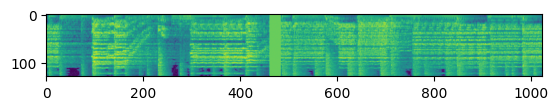

In [ ]:
plt.imshow(a_input.reshape(1024, 128).T)

In [ ]:
# from timm.models.vision_transformer import PatchEmbed
# img_size=224
# patch_size=16
# embed_dim=768
# patch_embed_a=PatchEmbed(img_size, patch_size, 1, embed_dim)
# pos_embed_a = torch.nn.Parameter(torch.zeros(1, patch_embed_a.num_patches, embed_dim), requires_grad=False)  # fixed sin-cos embedding
# modality_a =  torch.nn.Parameter(torch.zeros(1, 1, embed_dim))

# aud = a_input.unsqueeze(1).transpose(2, 3)
# aud = patch_embed_a(aud)
# aud = aud + pos_embed_a
# aud = aud + modality_a


In [ ]:
# img = v_input.T.squeeze()

# x_masked, mask, ids_restore = CAVMAE().random_masking_unstructured(x=img, mask_ratio=0.75)
# print(x_masked.shape)
# x=return_masked(x_masked)
# masked = CAVMAE().unpatchify().squeeze(0)

# plt.subplot(1, 2, 1)
# show_image(img, "original")

# plt.subplot(1, 2, 2)
# show_image(masked,"masked")
# plt.gcf().set_size_inches(15, 8)
# plt.show()

# CF

In [4]:
model = CAVMAEFT(label_dim=57)
#model = torch.nn.DataParallel(model)
if not isinstance(model, torch.nn.DataParallel):
    model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_cavmaeft_model.pth', map_location=device)
model.load_state_dict(sd, strict=False)

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


<All keys matched successfully>

In [5]:
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/mnt/g/My Drive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            output = model(a, v, mode="multimodal")
            torch.sigmoid(output)

        predictions = output.data.cpu().numpy()[0]

        sorted_indexes = np.argsort(predictions)[::-1]
        for k in range(3):
            print('- P: {}: {:.4f}, T: {}'.format(csvFile.iloc[sorted_indexes[k]]['display_name'], predictions[sorted_indexes[k]], labels[0]))
        print()
        break


- P: steel_guitar: 5.2109, T: steel_guitar
- P: acoustic_guitar: 5.0508, T: steel_guitar
- P: bassoon: 3.2012, T: steel_guitar



In [58]:
class ModelVis(CAVMAEFT):
    
    def random_masking_unstructured(self, x, mask_ratio):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.blocks_a:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list
    
    def visualize_v(self,x):
        v = self.patch_embed_v(x)
        v = v + self.pos_embed_v
        v = v + self.modality_v
        #v, mask_v, ids_restore_v = self.random_masking_unstructured(v, mask_ratio=0.75)
        att_list = []
        for blk in self.blocks_v:
            cur_att = self.get_att_map(blk, v)
            att_list.append(cur_att)
            v = blk(v)
        return att_list
        # keep only the output patch attention
                    
model = ModelVis(label_dim=57)
model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_cavmaeft_model.pth', map_location=device)
model.load_state_dict(sd)

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


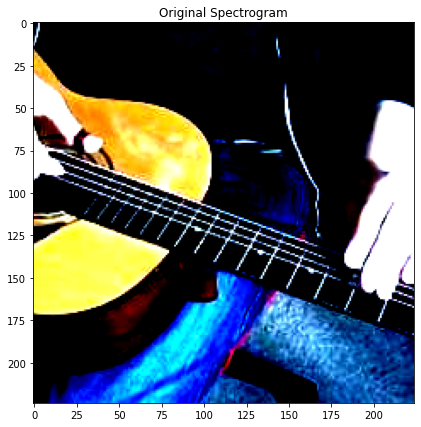

0.0051020407
0.29604843


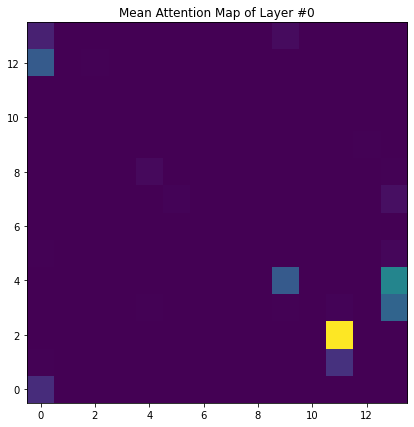

0.0051020402
0.23318166


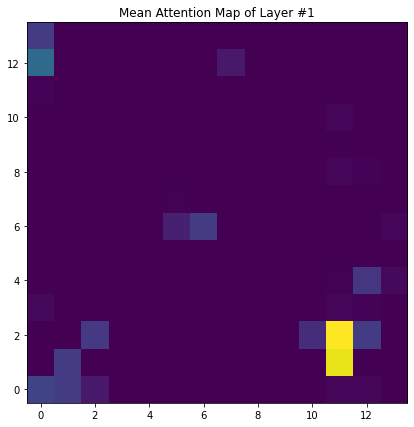

0.0051020407
0.15533608


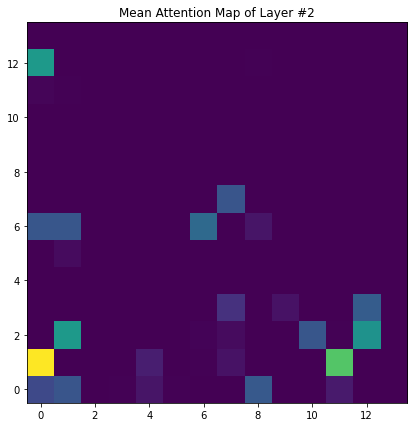

0.0051020402
0.13444471


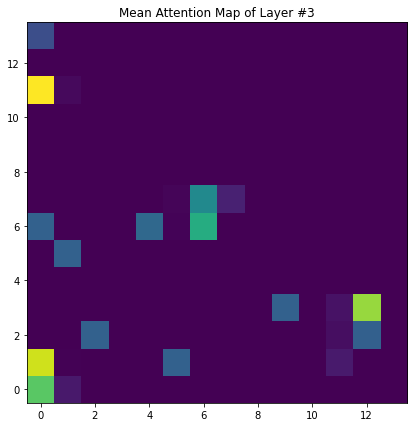

0.0051020407
0.14295371


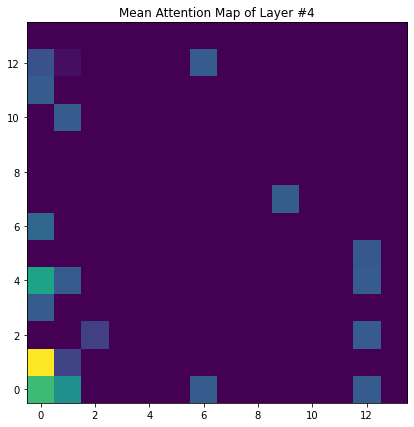

0.0051020407
0.11868034


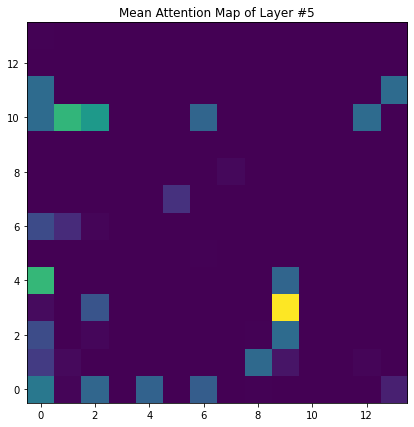

0.0051020407
0.124360785


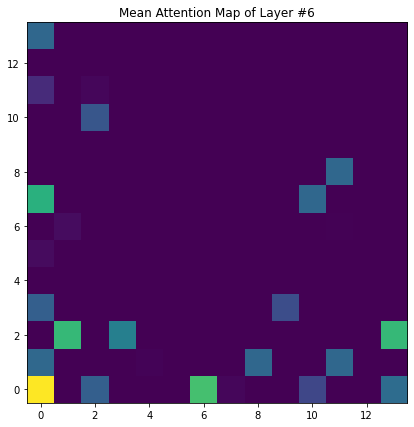

0.0051020402
0.17760117


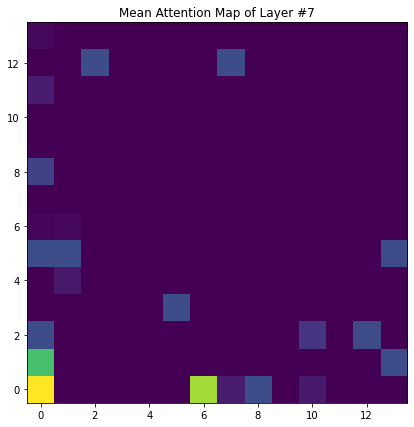

0.0051020407
0.08983161


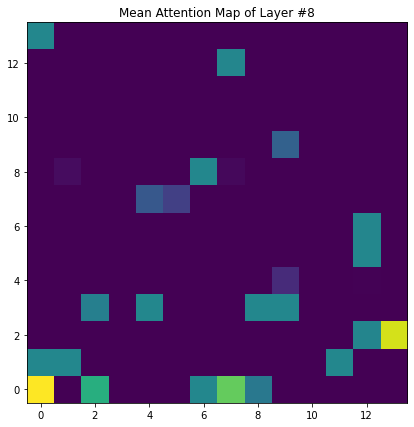

0.0051020407
0.09008484


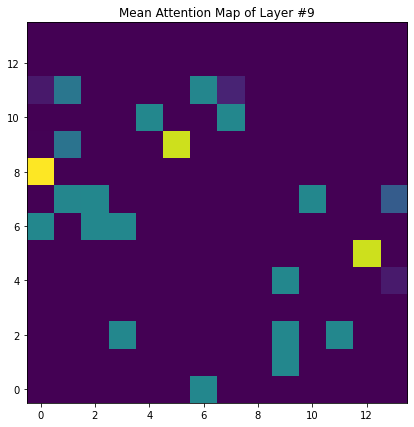

0.0051020407
0.12499258


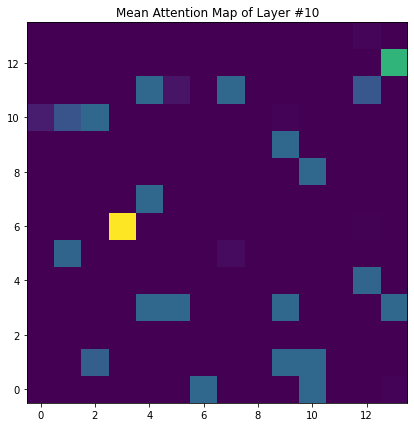

In [54]:
from matplotlib import pyplot as plt
img = torch.einsum('chw->hwc', v.squeeze(0))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img.squeeze(0).cpu().numpy())
plt.title('Original Spectrogram')
plt.show()
plt.close()

with torch.no_grad():
    with autocast():
        att_list = model.module.visualize_v(v)
for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    print(np.mean(att_list[i], axis=0))
    print(np.max(att_list[i]))

    att_list[i] = att_list[i].reshape(14, 14)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(att_list[i], origin='lower')
    plt.title('Mean Attention Map of Layer #{:d}'.format(i))
    plt.show()
    plt.close()

In [17]:
abc=np.zeros([1, 49, 768])
abc.shape[-2] // 16,abc.shape[-1] // 16

(3, 48)

# Visualization of the attention layer

In [188]:
class ModelVis(CAVMAEFT):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.blocks_a:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list
    
model = ModelVis(label_dim=57)
model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_cavmaeft_model.pth', map_location=device)
#sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/model_papers.pth', map_location=device)

model.load_state_dict(sd)

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


<All keys matched successfully>

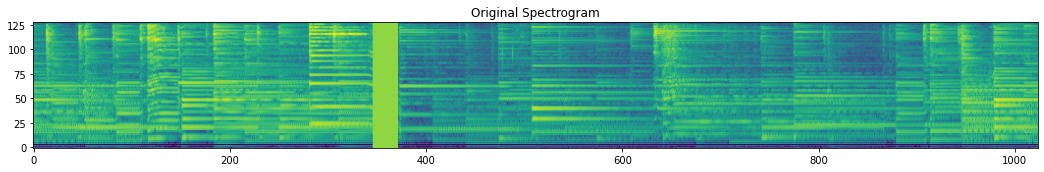

0.001953125
0.099158004


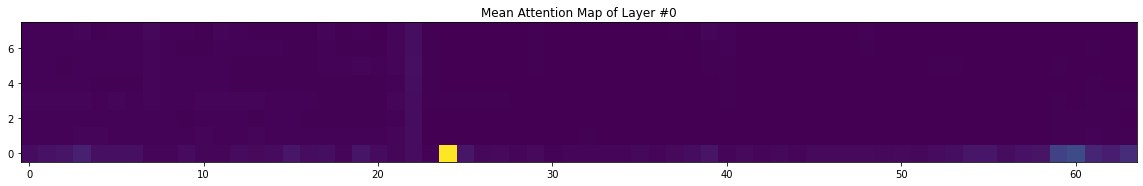

0.001953125
0.10263097


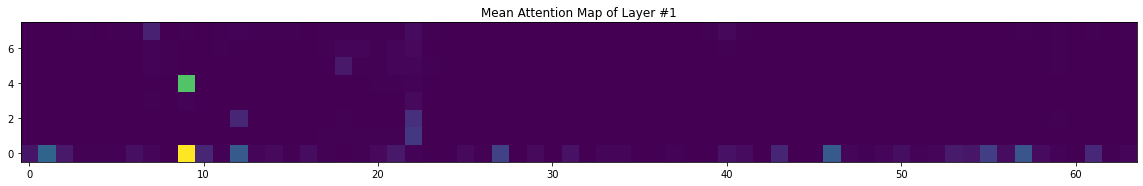

0.0019531249
0.10221918


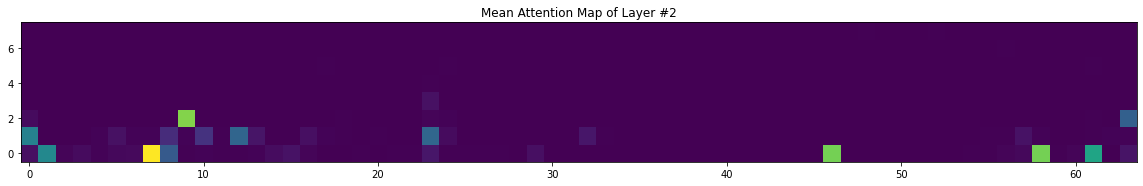

0.001953125
0.13081597


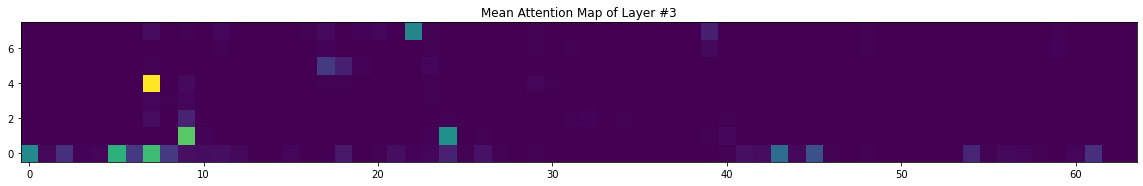

0.001953125
0.1563686


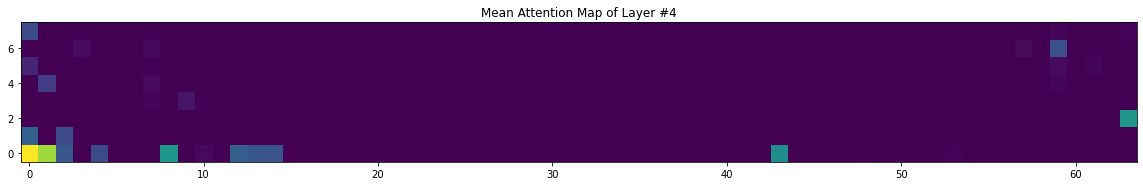

0.001953125
0.15717107


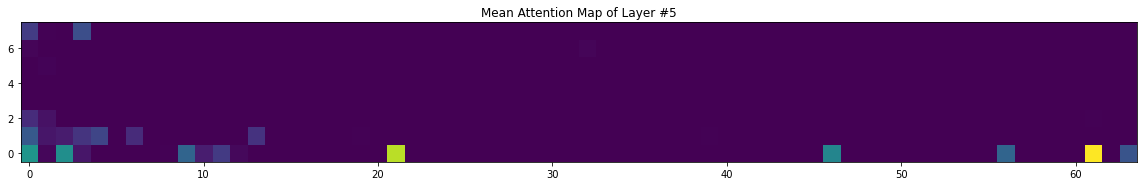

0.0019531252
0.16666022


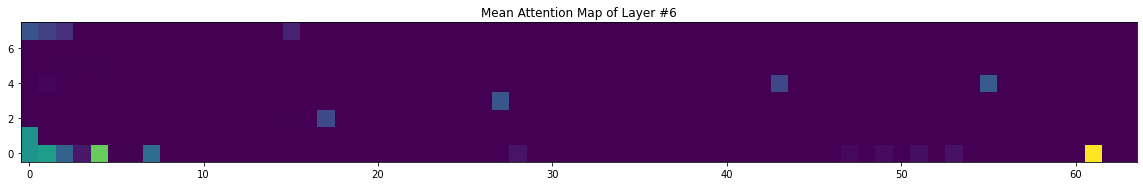

0.001953125
0.14483956


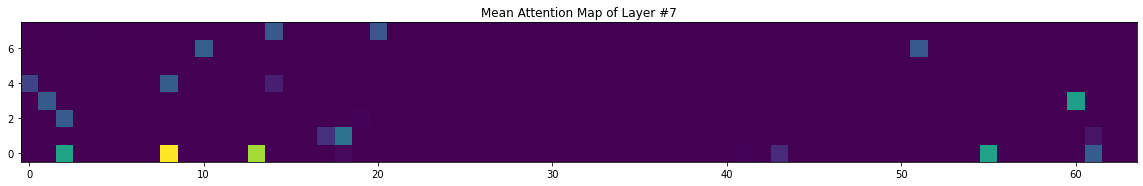

0.001953125
0.15861945


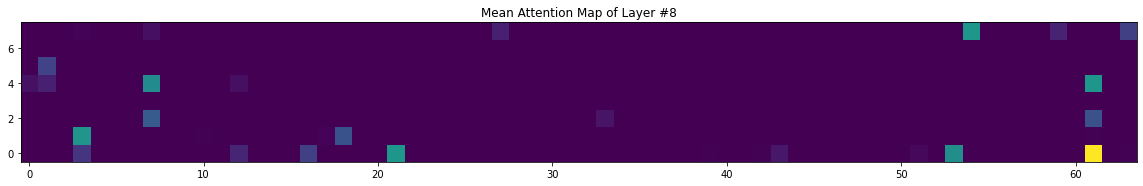

0.001953125
0.6666667


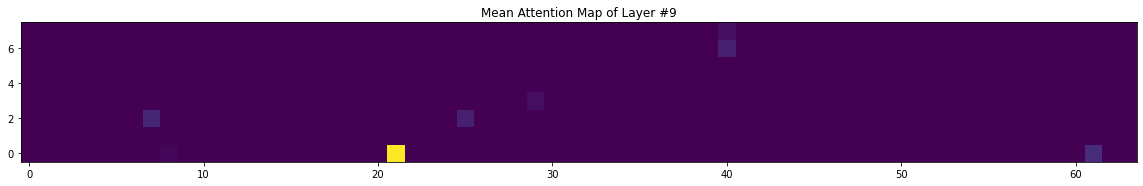

0.001953125
0.83322704


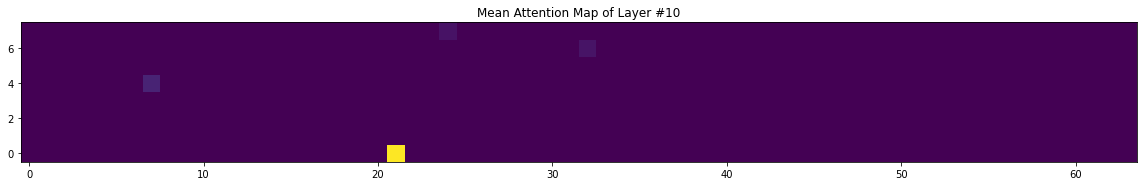

In [183]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(18, 5))
ax.imshow(a_input[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()

with torch.no_grad():
    with autocast():
        att_list = model.module.forward_visualization(a)
for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    print(np.mean(att_list[i], axis=0))
    print(np.max(att_list[i]))
    att_list[i] = att_list[i].reshape(8, 64)
    fig, ax = plt.subplots(figsize=(20, 17))
    ax.imshow(att_list[i], origin='lower')
    plt.title('Mean Attention Map of Layer #{:d}'.format(i))
    plt.show()
    plt.close()

In [186]:
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            att_list = model.module.forward_visualization(a)
        
        for i in range(len(att_list)):
            att_list[i] = att_list[i].data.cpu().numpy()
            att_list[i] = np.mean(att_list[i][0], axis=0)
            att_list[i] = np.mean(att_list[i][0:2], axis=0)
            print(np.mean(att_list[i], axis=0))
            print(np.max(att_list[i]))
            print()
    

0.001953125
0.086212315

0.0019531249
0.14421657

0.0019531249
0.06877123

0.001953125
0.08091498

0.001953125
0.08723531

0.001953125
0.12369336

0.001953125
0.086349756

0.001953125
0.09644666

0.001953125
0.17065935

0.0019531252
0.6788929

0.001953125
0.7083334

0.001953125
0.10640979

0.001953125
0.11582197

0.001953125
0.08699773

0.0019531249
0.09770583

0.001953125
0.08548184

0.001953125
0.083425105

0.001953125
0.08431061

0.001953125
0.120366514

0.001953125
0.29184103

0.001953125
0.91486096

0.001953125
0.75

0.001953125
0.01725512

0.001953125
0.14215848

0.0019531249
0.1387194

0.001953125
0.118256345

0.001953125
0.18157358

0.0019531249
0.22805917

0.001953125
0.1999794

0.0019531249
0.16067748

0.001953125
0.23009878

0.0019531248
0.54166645

0.0019531252
0.6666667

0.001953125
0.071827814

0.001953125
0.1323576

0.001953125
0.12048793

0.001953125
0.08559561

0.001953125
0.14586262

0.001953125
0.09265912

0.0019531249
0.13310465

0.0019531249
0.08369546

0.001953125

In [67]:
class ModelVis(CAVMAEFT):
    
    def random_masking_unstructured(self, x, mask_ratio):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def visualize_a(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.blocks_a:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list
    
    def visualize_v(self,x):
        v = self.patch_embed_v(x)
        v = v + self.pos_embed_v
        v = v + self.modality_v
        #v, mask_v, ids_restore_v = self.random_masking_unstructured(v, mask_ratio=0.75)
        att_list = []
        for blk in self.blocks_v:
            cur_att = self.get_att_map(blk, v)
            att_list.append(cur_att)
            v = blk(v)
        return att_list
        # keep only the output patch attention
    def visualize_u(self,a,v):
        x = a.unsqueeze(1)
        x = x.transpose(2, 3)
        B = x.shape[0]
        x = self.patch_embed_a(x)
        x = x + self.modality_a
        x = x + self.pos_embed_a
        
        v = self.patch_embed_v(v)
        v = v + self.pos_embed_v
        v = v + self.modality_v
        
        for blk in self.blocks_a:
            x = blk(x)

        for blk in self.blocks_v:
            v = blk(v)

        x = torch.cat((x, v), dim=1)
        att_list = []
        for blk in self.blocks_u:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list 
        
                    
model = ModelVis(label_dim=57)
model = torch.nn.DataParallel(model)
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_cavmaeft_model.pth', map_location=device)
model.load_state_dict(sd)

Use norm_pix_loss:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])


<All keys matched successfully>

['steel_guitar']
0.0014124293
0.5


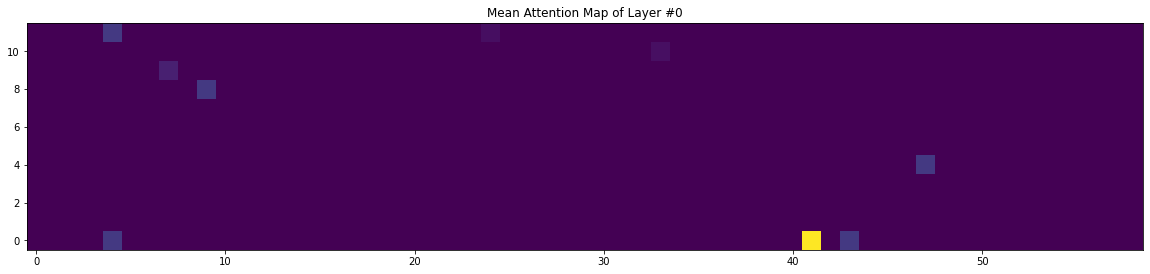

['flute']
0.0014124294
0.50045776


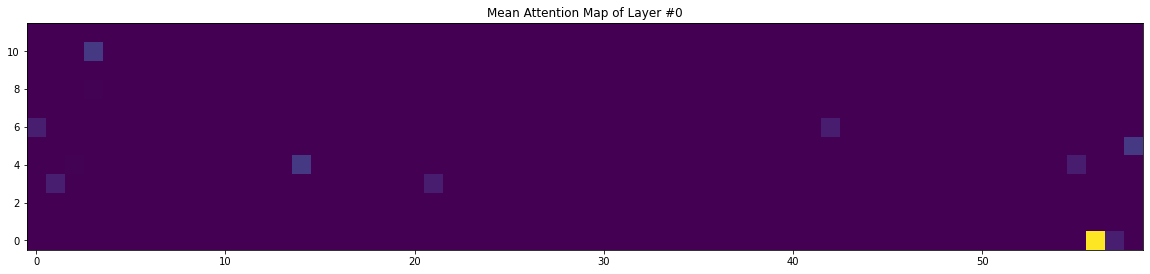

['didgeridoo']
0.0014124294
0.6666667


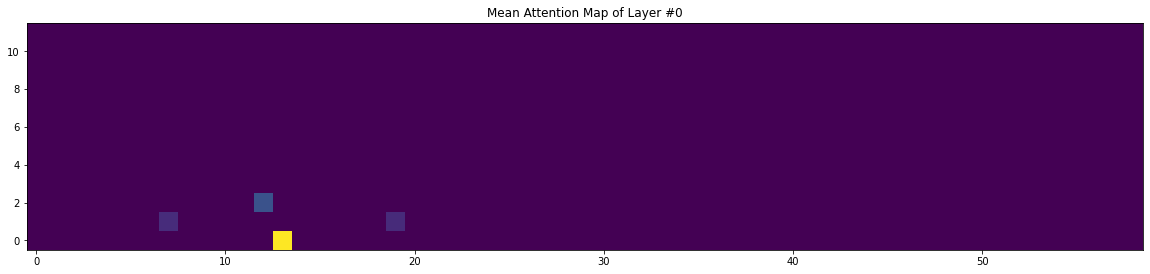

['trombone']
0.0014124294
0.5


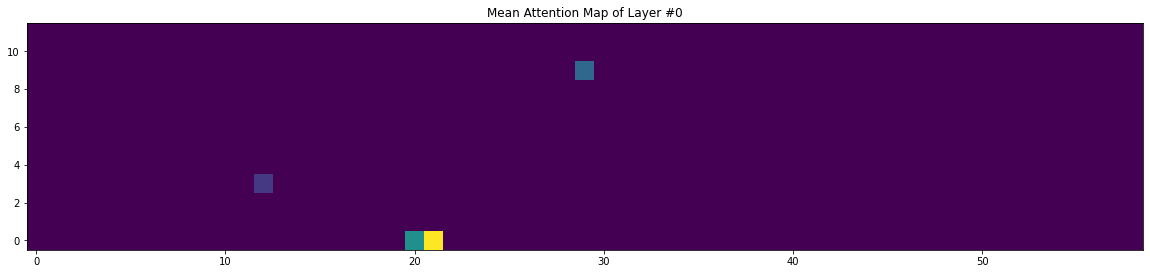

['piano']
0.0014124294
0.7560656


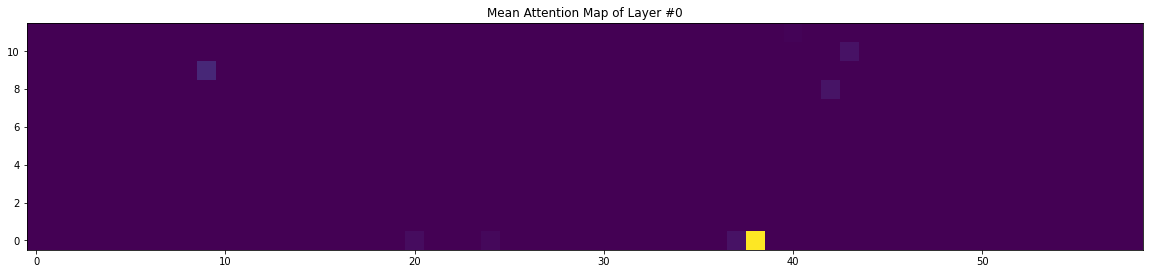

In [74]:
for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
    print(labels)
    a = a_input.to(device)
    v = v_input.to(device)
    with torch.no_grad():
        with autocast():
            att_list = model.module.visualize_u(a,v)
    for i in range(len(att_list)):
        att_list[i] = att_list[i].data.cpu().numpy()
        att_list[i] = np.mean(att_list[i][0], axis=0)
        att_list[i] = np.mean(att_list[i][0:2], axis=0)
        print(np.mean(att_list[i], axis=0))
        print(np.max(att_list[i]))
        att_list[i] = att_list[i].reshape(12, 59)
        fig, ax = plt.subplots(figsize=(20, 17))
        ax.imshow(att_list[i], origin='lower')
        plt.title('Mean Attention Map of Layer #{:d}'.format(i))
        plt.show()
        plt.close()

# Masked visualization

In [193]:
model = CAVMAE(audio_length=1024,modality_specific_depth=11)
model = torch.nn.DataParallel(model)
#mdl_weight = torch.load(args.pretrain_path, map_location=torch.device('cpu'))
sd = torch.load('/mnt/g/My Drive/Thesis/src/pretrained/best_cavmae_model.pth', map_location=device)
model.load_state_dict(sd)

<All keys matched successfully>

In [195]:
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/mnt/g/My Drive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)


masking_ratio=0.75
mae_loss_weight=1.0
contrast_loss_weight=0.01
mask_mode='unstructured'
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            loss, loss_mae, loss_mae_a, ids_restore_a, loss_mae_v, ids_restore_v, loss_c, mask_a, mask_v, c_acc, pred_a, pred_v = model(a, v, masking_ratio, masking_ratio, mae_loss_weight=mae_loss_weight, contrast_loss_weight=contrast_loss_weight, mask_mode=mask_mode)
            print(i,loss, loss_mae, loss_mae_a, loss_mae_v, loss_c, c_acc)
            print()

/tmp/ipykernel_1015/903491464.py:132: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(self.im_res, interpolation=PIL.Image.BICUBIC),


0 tensor(1.5168, device='cuda:0') tensor(1.5168, device='cuda:0') tensor(0.4195, device='cuda:0') tensor(1.0973, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

1 tensor(1.9697, device='cuda:0') tensor(1.9697, device='cuda:0') tensor(0.4431, device='cuda:0') tensor(1.5266, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

2 tensor(1.7955, device='cuda:0') tensor(1.7955, device='cuda:0') tensor(0.4847, device='cuda:0') tensor(1.3108, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

3 tensor(3.1896, device='cuda:0') tensor(3.1896, device='cuda:0') tensor(1.4561, device='cuda:0') tensor(1.7335, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')

4 tensor(2.4810, device='cuda:0') tensor(2.4810, device='cuda:0') tensor(0.5872, device='cuda:0') tensor(1.8938, device='cuda:0') tensor(-0., device='cuda:0') tensor(1., device='cuda:0')



/tmp/ipykernel_1015/1047275406.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b = True, color ='grey',
/tmp/ipykernel_1015/1047275406.py:31: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[1].grid(b = True, color ='grey',


<Figure size 800x480 with 0 Axes>

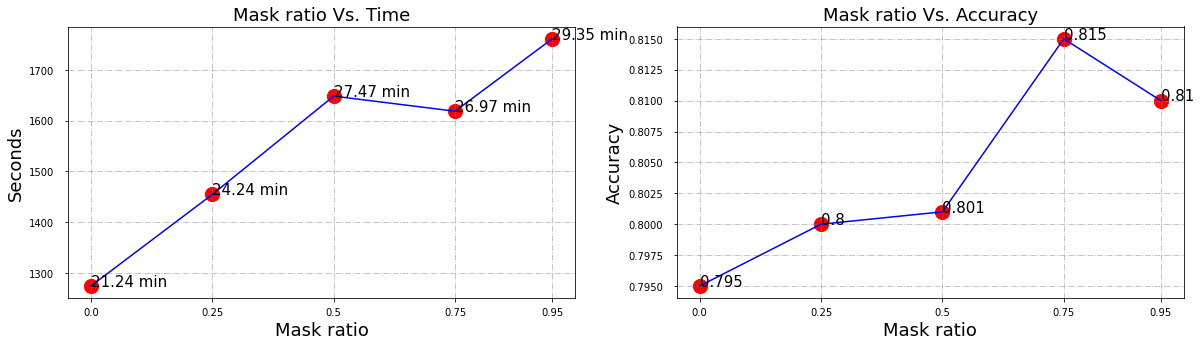

In [280]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)


figure, ax = plt.subplots(1, 2, figsize=(20,5)) 

aaa = [0.0, 0.25, 0.50, 0.75, 0.95]
bbb = [1274.268,1454.579,1648.168,1618.456 ,1760.996]#1244.238, #1618.456
ccc = [0.795, 0.8, 0.801,0.815, 0.81]


ax[0].xaxis.set_tick_params(pad = 5)
ax[0].yaxis.set_tick_params(pad = 10)

ax[0].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[0].scatter(aaa,bbb, marker='o',color='r',s=200)
ax[0].plot(aaa,bbb,color='b')
ax[0].set_xticks(aaa, aaa)
for i, txt in enumerate(bbb):
    ax[0].annotate(str(round(txt/60,2))+' min', (aaa[i], bbb[i]),fontsize=15)
ax[0].set_title("Mask ratio Vs. Time", fontsize=18) 
ax[0].set_ylabel("Seconds", fontsize=18)
ax[0].set_xlabel("Mask ratio", fontsize=18)


ax[1].xaxis.set_tick_params(pad = 5)
ax[1].yaxis.set_tick_params(pad = 10)

ax[1].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[1].scatter(aaa,ccc, marker='o',color='r',s=200)
ax[1].plot(aaa,ccc,color='b')
ax[1].set_xticks(aaa, aaa, fontsize=10)
for i, txt in enumerate(ccc):
    ax[1].annotate(str(txt), (aaa[i], ccc[i]),fontsize=15)
ax[1].set_title("Mask ratio Vs. Accuracy", fontsize=18) 
ax[1].set_ylabel("Accuracy", fontsize=18)
ax[1].set_xlabel("Mask ratio", fontsize=18)

plt.show()

/tmp/ipykernel_177/1459825479.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b = True, color ='grey',
/tmp/ipykernel_177/1459825479.py:31: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[1].grid(b = True, color ='grey',


<Figure size 800x480 with 0 Axes>

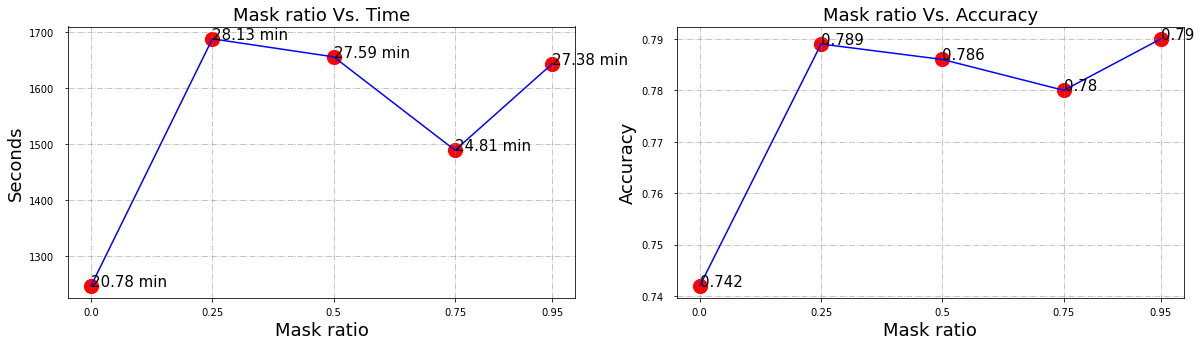

In [2]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)


figure, ax = plt.subplots(1, 2, figsize=(20,5)) 

aaa = [0.0, 0.25, 0.50, 0.75, 0.95]
bbb = [1246.583,1687.57,1655.436,1488.766,1643.04]#1244.238, #1618.456
ccc = [0.742, 0.789, 0.786, 0.78, 0.79]


ax[0].xaxis.set_tick_params(pad = 5)
ax[0].yaxis.set_tick_params(pad = 10)

ax[0].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[0].scatter(aaa,bbb, marker='o',color='r',s=200)
ax[0].plot(aaa,bbb,color='b')
ax[0].set_xticks(aaa, aaa)
for i, txt in enumerate(bbb):
    ax[0].annotate(str(round(txt/60,2))+' min', (aaa[i], bbb[i]),fontsize=15)
ax[0].set_title("Mask ratio Vs. Time", fontsize=18) 
ax[0].set_ylabel("Seconds", fontsize=18)
ax[0].set_xlabel("Mask ratio", fontsize=18)


ax[1].xaxis.set_tick_params(pad = 5)
ax[1].yaxis.set_tick_params(pad = 10)

ax[1].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[1].scatter(aaa,ccc, marker='o',color='r',s=200)
ax[1].plot(aaa,ccc,color='b')
ax[1].set_xticks(aaa, aaa, fontsize=10)
for i, txt in enumerate(ccc):
    ax[1].annotate(str(txt), (aaa[i], ccc[i]),fontsize=15)
ax[1].set_title("Mask ratio Vs. Accuracy", fontsize=18) 
ax[1].set_ylabel("Accuracy", fontsize=18)
ax[1].set_xlabel("Mask ratio", fontsize=18)

plt.show()

/tmp/ipykernel_177/764509103.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b = True, color ='grey',
/tmp/ipykernel_177/764509103.py:31: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[1].grid(b = True, color ='grey',
/tmp/ipykernel_177/764509103.py:52: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b = True, color ='grey',
/tmp/ipykernel_177/764509103.py:68: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[1].grid(b = True, color ='grey',


<Figure size 800x480 with 0 Axes>

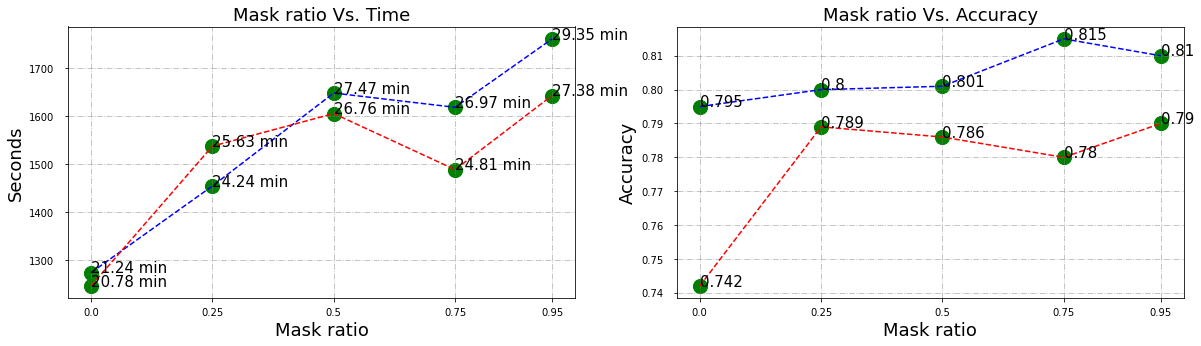

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)


figure, ax = plt.subplots(1, 2, figsize=(20,5)) 

aaa0 = [0.0, 0.25, 0.50, 0.75, 0.95]
bbb0 = [1274.268,1454.579,1648.168,1618.456 ,1760.996]#1244.238, #1618.456
ccc0 = [0.795, 0.8, 0.801,0.815, 0.81]


ax[0].xaxis.set_tick_params(pad = 5)
ax[0].yaxis.set_tick_params(pad = 10)

ax[0].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[0].scatter(aaa0,bbb0, marker='o',color='g',s=200)
ax[0].plot(aaa0,bbb0,color='b',linestyle ='--')
ax[0].set_xticks(aaa0, aaa0)
for i, txt in enumerate(bbb0):
    ax[0].annotate(str(round(txt/60,2))+' min', (aaa0[i], bbb0[i]),fontsize=15)
ax[0].set_title("Mask ratio Vs. Time", fontsize=18) 
ax[0].set_ylabel("Seconds", fontsize=18)
ax[0].set_xlabel("Mask ratio", fontsize=18)


ax[1].xaxis.set_tick_params(pad = 5)
ax[1].yaxis.set_tick_params(pad = 10)

ax[1].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[1].scatter(aaa0,ccc0, marker='o',color='g',s=200)
ax[1].plot(aaa0,ccc0,color='b',linestyle= '--')
ax[1].set_xticks(aaa0, aaa0, fontsize=10)
for i, txt in enumerate(ccc0):
    ax[1].annotate(str(txt), (aaa0[i], ccc0[i]),fontsize=15)
ax[1].set_title("Mask ratio Vs. Accuracy", fontsize=18) 
ax[1].set_ylabel("Accuracy", fontsize=18)
ax[1].set_xlabel("Mask ratio", fontsize=18)




aaa = [0.0, 0.25, 0.50, 0.75, 0.95]
bbb = [1246.583,1537.57,1605.436,1488.766,1643.04]#1244.238, #1618.456
ccc = [0.742, 0.789, 0.786, 0.78, 0.79]
ax[0].xaxis.set_tick_params(pad = 5)
ax[0].yaxis.set_tick_params(pad = 10)

ax[0].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[0].scatter(aaa,bbb, marker='o',color='g',s=200)
ax[0].plot(aaa,bbb,color='r',linestyle= '--')
ax[0].set_xticks(aaa, aaa)
for i, txt in enumerate(bbb):
    ax[0].annotate(str(round(txt/60,2))+' min', (aaa[i], bbb[i]),fontsize=15)
ax[0].set_title("Mask ratio Vs. Time", fontsize=18) 
ax[0].set_ylabel("Seconds", fontsize=18)
ax[0].set_xlabel("Mask ratio", fontsize=18)


ax[1].xaxis.set_tick_params(pad = 5)
ax[1].yaxis.set_tick_params(pad = 10)

ax[1].grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.9,
        alpha = 0.5)
ax[1].scatter(aaa,ccc, marker='o',color='g',s=200)
ax[1].plot(aaa,ccc,color='r',linestyle ='--')
ax[1].set_xticks(aaa, aaa, fontsize=10)
for i, txt in enumerate(ccc):
    ax[1].annotate(str(txt), (aaa[i], ccc[i]),fontsize=15)
ax[1].set_title("Mask ratio Vs. Accuracy", fontsize=18) 
ax[1].set_ylabel("Accuracy", fontsize=18)
ax[1].set_xlabel("Mask ratio", fontsize=18)

plt.show()

In [ ]:
def calculate_stats(output, target):

    classes_num = target.shape[-1]
    stats = []

    # Accuracy, only used for single-label classification such as esc-50, not for multiple label one such as AudioSet
    acc = metrics.accuracy_score(np.argmax(target, 1), np.argmax(output, 1))

    # Class-wise statistics
    for k in range(classes_num):

        # Average precision
        avg_precision = metrics.average_precision_score(
            target[:, k], output[:, k], average=None)

        # AUC
        try:
            auc = metrics.roc_auc_score(target[:, k], output[:, k], average=None)

            # Precisions, recalls
            (precisions, recalls, thresholds) = metrics.precision_recall_curve(
                target[:, k], output[:, k])

            # FPR, TPR
            (fpr, tpr, thresholds) = metrics.roc_curve(target[:, k], output[:, k])

            save_every_steps = 1000     # Sample statistics to reduce size
            dict = {'precisions': precisions[0::save_every_steps],
                    'recalls': recalls[0::save_every_steps],
                    'AP': avg_precision,
                    'fpr': fpr[0::save_every_steps],
                    'fnr': 1. - tpr[0::save_every_steps],
                    'auc': auc,
                    # note acc is not class-wise, this is just to keep consistent with other metrics
                    'acc': acc
                    }
        except:
            dict = {'precisions': -1,
                    'recalls': -1,
                    'AP': avg_precision,
                    'fpr': -1,
                    'fnr': -1,
                    'auc': -1,
                    # note acc is not class-wise, this is just to keep consistent with other metrics
                    'acc': acc
                    }
            print('class {:s} no true sample'.format(str(k)))
        stats.append(dict)

    return stats

In [ ]:
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0.0, 'dataset': 'vggsound', 'mode':'train', 'mean':-5.081, 'std':4.4849, 'noise':True, 'label_smooth': 0}# , 'im_res': im_res
tr = '/content/drive/MyDrive/Thesis/src/TEST.json'

tr_loader = torch.utils.data.DataLoader(AudiosetDataset(tr, label_csv=csvFile, audio_conf=audio_conf, verbose=False),
             batch_size=1, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

loss_fn = torch.nn.CrossEntropyLoss()
A_predictions, A_targets, A_loss = [], [], []
with torch.no_grad():
    for i, (a_input, v_input, label_index, labels_true) in enumerate(tr_loader):
        a = a_input.to(device)
        v = v_input.to(device)
        with autocast():
            output = model(a, v, mode="multimodal")

        predictions = output.to('cpu').detach()
        A_predictions.append(predictions)
        A_targets.append(label_index)
        labels = label_index.to(device)
        loss = loss_fn(output, labels)
        A_loss.append(loss.to('cpu').detach())

    audio_output = torch.cat(A_predictions)
    target = torch.cat(A_targets)

stats = calculate_stats(audio_output, target)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

class 5 no true sample
class 6 no true sample
class 7 no true sample
class 8 no true sample
class 9 no true sample
class 10 no true sample
class 11 no true sample
class 12 no true sample
class 13 no true sample
class 14 no true sample
class 15 no true sample
class 16 no true sample
class 17 no true sample
class 18 no true sample
class 19 no true sample
class 20 no true sample
class 21 no true sample
class 22 no true sample
class 23 no true sample
class 24 no true sample
class 25 no true sample
class 26 no true sample
class 27 no true sample
class 28 no true sample
class 29 no true sample
class 30 no true sample
class 31 no true sample
class 32 no true sample
class 33 no true sample
class 34 no true sample
class 35 no true sample
class 36 no true sample
class 37 no true sample
class 38 no true sample
class 39 no true sample
class 40 no true sample
class 41 no true sample
class 42 no true sample
class 43 no true sample
class 44 no true sample
class 45 no true sample
class 46 no true samp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

In [ ]:
stats

[{'precisions': array([0.2]),
  'recalls': array([1.]),
  'AP': 0.2,
  'fpr': array([0.]),
  'fnr': array([1.]),
  'auc': 0.0,
  'acc': 0.0},
 {'precisions': array([0.2]),
  'recalls': array([1.]),
  'AP': 0.3333333333333333,
  'fpr': array([0.]),
  'fnr': array([1.]),
  'auc': 0.5,
  'acc': 0.0},
 {'precisions': array([0.2]),
  'recalls': array([1.]),
  'AP': 0.2,
  'fpr': array([0.]),
  'fnr': array([1.]),
  'auc': 0.0,
  'acc': 0.0},
 {'precisions': array([0.2]),
  'recalls': array([1.]),
  'AP': 0.2,
  'fpr': array([0.]),
  'fnr': array([1.]),
  'auc': 0.0,
  'acc': 0.0},
 {'precisions': array([0.2]),
  'recalls': array([1.]),
  'AP': 1.0,
  'fpr': array([0.]),
  'fnr': array([1.]),
  'auc': 1.0,
  'acc': 0.0},
 {'precisions': -1,
  'recalls': -1,
  'AP': -0.0,
  'fpr': -1,
  'fnr': -1,
  'auc': -1,
  'acc': 0.0},
 {'precisions': -1,
  'recalls': -1,
  'AP': -0.0,
  'fpr': -1,
  'fnr': -1,
  'auc': -1,
  'acc': 0.0},
 {'precisions': -1,
  'recalls': -1,
  'AP': -0.0,
  'fpr': -1,
 

Confusion Matrix:
[[3 2]
 [1 4]]
Accuracy: 0.7
Precision: 0.6666666666666666
Recall: 0.8
F1-Score: 0.7272727272727272
ROC AUC: 0.7000000000000001


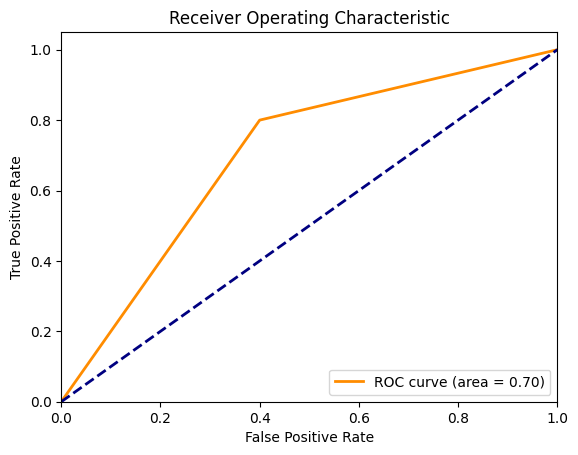

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# True labels
y_true = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
# Predicted labels
y_pred = [0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
# Precision
precision = precision_score(y_true, y_pred)
# Recall
recall = recall_score(y_true, y_pred)
# F1-Score
f1 = f1_score(y_true, y_pred)
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC:", roc_auc)

import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()

# Plot the ROC curve with a label displaying the ROC AUC score
plt.plot(fpr, tpr, color='darkorange', lw=2,
		label='ROC curve (area = %0.2f)' % roc_auc)

# Plot a dashed diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the x and y-axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Label the x and y-axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic')

# Add a legend to the plot
plt.legend(loc='lower right')

# Display the ROC curve plot
plt.show()
